# New Analyses: YAASS and SCORE

### The dataset below includes demographic information and multiple clinical measures taken in 3 populations: healthy controls, those at clinical high risk for psychosis, and those diagnosed with schizophrenia. This is a follow-up to the YAASS.ipynb with FHR removed due to missing clinical measures.

In [1]:
# Get the username and use that to set-up paths to data and figures
uname  = !whoami
uname = uname[0]
path2code = '/Users/' + uname + '/Work/Expts/Code/'
path2data = '/Users/' + uname + '/Work/Expts/YAASS/Data/'
path2analysis = '/Users/' + uname + '/Work/Expts/YAASS/Analysis/'
path2figs = '/Users/' + uname + '/Work/Expts/SOURCE/Analysis/Figures/'

In [2]:
%cd {path2code}

import warnings; warnings.simplefilter('ignore')
import csv, misc, os, random, re, SelfRep
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import HTML
import scipy as sp
from scipy import stats
from scipy.stats import zscore
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext rpy2.ipython

%R suppressMessages(library('lmerTest'))
%R suppressMessages(library('lsmeans'))
%R lsm.options(disable.pbkrtest=TRUE)
%R suppressMessages(library('effsize')) # Can use this to estimate Cohen's d
%R suppressMessages(library('afex'))
%R suppressMessages(library('QuantPsyc')) #helpful for extracting betas from hierarchical regresssions
%R suppressMessages(library('vcd')) # useful for getting effect sizes from chi-square tests
%R suppressMessages(library('scales'))

/Users/elyssabarrick/Work/Expts/Code


array(['scales', 'vcd', 'grid', 'QuantPsyc', 'MASS', 'boot', 'afex',
       'reshape2', 'effsize', 'lsmeans', 'estimability', 'lmerTest',
       'lme4', 'Matrix', 'tools', 'stats', 'graphics', 'grDevices',
       'utils', 'datasets', 'methods', 'base'], 
      dtype='<U12')

In [101]:
sns.set_context(font_scale=2.5)

# Dataframe

In [3]:
#Load in SHL dataframe containing SCORE and YAASS data
beh = pd.read_csv(path2data + 'BehavioralData_05.22.17.csv')

In [4]:
#Load in SCORE PANSS data
sx_SZ = pd.read_excel(path2data + 'PANSS_SCORE.xlsx', sheetname='EB')

In [5]:
#Load in YAASS PANSS data
sx_chr = pd.read_excel(path2data + 'YAASS_Clinical_Data.xls', sheetname='EB')

In [6]:
#Join the 2 PANSS dataframes
s = pd.concat([sx_SZ, sx_chr])

In [7]:
# Merge PANSS dataframe with SHL dataframe to have all scores together
raw = pd.merge(beh, s, on='ID')

In [8]:
#save dataframe to csv
raw.to_csv('raw_new.csv')

In [9]:
# #creating log transformation column for the values of interest

# raw['lnIRI_EC_total'] = raw.IRI_EC_total.apply(np.log)
# raw['lnIRI_PT_total'] = raw.IRI_PT_total.apply(np.log)
# raw['lnIRI_PD_total'] = raw.IRI_PD_total.apply(np.log)
# raw['lnIRI_FS_total'] = raw.IRI_FS_total.apply(np.log)

# raw['lnPANSS_PA'] = raw.PANSS_PA.apply(np.log)
# raw['lnPANSS_NA'] = raw.PANSS_NA.apply(np.log)
# raw['lnPANSS_DA'] = raw.PANSS_DA.apply(np.log)
# raw['lnPANSS_EA'] = raw.PANSS_EA.apply(np.log)
# raw['lnPANSS_Dep_Anx'] = raw.PANSS_Dep_Anx.apply(np.log)
# raw_columns = ['ID', 'Group', 'Gender', 'Age', 'Education', 'Ethnicity', 'IQ','DSMDisorder', 'DSMDisorderType',
#                'DSMcomorbidities', 'IRI_EC_total','lnIRI_EC_total','IRI_FS_total','lnIRI_FS_total', 'IRI_PD_total',
#                'lnIRI_PD_total','IRI_PT_total', 'lnIRI_PT_total' ,'Chapman_MIS', 'Chapman_PAS', 'Chapman_PhAS', 
#                'Chapman_RTS', 'Chapman_SocAnh','Medication', 'PANAS_NA', 'PANAS_PA','SIPS_Disorganized',
#                'SIPS_General', 'SIPS_Negative', 'SIPS_Positive','SocAdjScale_SocialLeisure','SocAdjScale_Work', 
#                'GFS_Role','GFS_Social', 'Present_Clinical', 'PANSS_PA','lnPANSS_PA', 'PANSS_NA', 'lnPANSS_NA',
#                'PANSS_DA', 'lnPANSS_DA','PANSS_EA', 'lnPANSS_EA','PANSS_Dep_Anx', 'lnPANSS_Dep_Anx','PANSS_Other',]

In [10]:
# raw = raw.reindex(columns=raw_columns)

# Outliers

In [11]:
#Function to determine outliers by group. Input is column name.

def outcheck(colname):
    hc_outs = []
    hc_df = raw[raw.Group == 'HC']
    hc_high = (hc_df[colname].mean()) + (hc_df[colname].std()) * 2.5
    hc_low = (hc_df[colname].mean()) - (hc_df[colname].std()) * 2.5
    for i, row_i in hc_df.iterrows():
        if (row_i[colname] > hc_high) or (row_i[colname] < hc_low):
            hc_outs.append(1)
        else:
            hc_outs.append(0)
    valname = colname + '_outliers'
    hc_df[valname] = hc_outs
    
    chr_outs = []
    chr_df = raw[raw.Group == 'CHR']
    chr_high = (chr_df[colname].mean()) + (chr_df[colname].std()) * 2.5
    chr_low = (chr_df[colname].mean()) - (chr_df[colname].std()) * 2.5
    for i, row_i in chr_df.iterrows():
        if (row_i[colname] > chr_high) or (row_i[colname] < chr_low):
            chr_outs.append(1)
        else:
            chr_outs.append(0)
    valname = colname + '_outliers'
    chr_df[valname] = chr_outs
    
    sz_outs = []
    sz_df = raw[raw.Group == 'SZ']
    sz_high = (sz_df[colname].mean()) + (sz_df[colname].std()) * 2.5
    sz_low = (sz_df[colname].mean()) - (sz_df[colname].std()) * 2.5
    for i, row_i in sz_df.iterrows():
        if (row_i[colname] > sz_high) or (row_i[colname] < sz_low):
            sz_outs.append(1)
        else:
            sz_outs.append(0)
    valname = colname + '_outliers'
    sz_df[valname] = sz_outs
    
    out = pd.concat([hc_df, chr_df, sz_df])
    return out

In [12]:
#Running the outlier check for measures of interest

raw = outcheck('IRI_EC_total')
raw = outcheck('IRI_FS_total')
raw=outcheck('IRI_PT_total')
raw = outcheck('IRI_PD_total')

raw = outcheck('SocAdjScale_SocialLeisure')

raw = outcheck('PANSS_PA')
raw = outcheck('PANSS_NA')
raw = outcheck('PANSS_DA')
raw = outcheck('PANSS_EA')
raw = outcheck('PANSS_Dep_Anx')

## IRI Outliers

In [13]:
#Make IRI outlier DF - none for PD or FS; after SHL checked skew/kurtosis, winsorized the HC outlier for 
#IRI_PT and IRI_EC

IRI_outs = raw[['ID', 'Group', 'IRI_EC_total', 'IRI_EC_total_outliers','IRI_PD_total','IRI_PD_total_outliers',
               'IRI_PT_total','IRI_PT_total_outliers','IRI_FS_total','IRI_FS_total_outliers']].copy()


### IRI_EC

In [14]:
IRI_outs.loc[IRI_outs['IRI_EC_total_outliers'] == 1]

,ID,Group,IRI_EC_total,IRI_EC_total_outliers,IRI_PD_total,IRI_PD_total_outliers,IRI_PT_total,IRI_PT_total_outliers,IRI_FS_total,IRI_FS_total_outliers
74,26142,CHR,16.0,1,17.0,0,25.0,0,36.0,0


In [15]:
raw.IRI_EC_total.describe()

count    82.000000
mean     31.200000
std       5.781708
min      16.000000
25%      28.000000
50%      31.000000
75%      35.000000
max      42.000000
Name: IRI_EC_total, dtype: float64

### IRI_PT

In [16]:
IRI_outs.loc[IRI_outs['IRI_PT_total_outliers'] == 1]

,ID,Group,IRI_EC_total,IRI_EC_total_outliers,IRI_PD_total,IRI_PD_total_outliers,IRI_PT_total,IRI_PT_total_outliers,IRI_FS_total,IRI_FS_total_outliers


In [17]:
raw.IRI_PT_total.describe()

count    82.000000
mean     30.601220
std       5.105371
min      20.000000
25%      27.000000
50%      30.500000
75%      34.000000
max      42.000000
Name: IRI_PT_total, dtype: float64

## SAS Outliers

In [18]:
#Make SAS outlier df

sas_outs = raw[['ID', 'Group', 'SocAdjScale_SocialLeisure','SocAdjScale_SocialLeisure_outliers']].copy()
sas_outs.loc[sas_outs['SocAdjScale_SocialLeisure_outliers'] == 1]

,ID,Group,SocAdjScale_SocialLeisure,SocAdjScale_SocialLeisure_outliers
27,27121,HC,79.0,1
39,27206,HC,85.0,1


In [20]:
print ('Test for Skewness')
r=raw.groupby('Group')
r['SocAdjScale_SocialLeisure'].skew()

Test for Skewness


Group
CHR   -0.343502
HC     1.554741
SZ     0.542476
Name: SocAdjScale_SocialLeisure, dtype: float64

In [21]:
g = raw[['Group','SocAdjScale_SocialLeisure']].copy()
print ('Test for Kurtosis')
g.groupby('Group').apply(pd.DataFrame.kurt)

Test for Kurtosis


,SocAdjScale_SocialLeisure
Group,
CHR,-1.146985
HC,2.952883
SZ,-0.549414


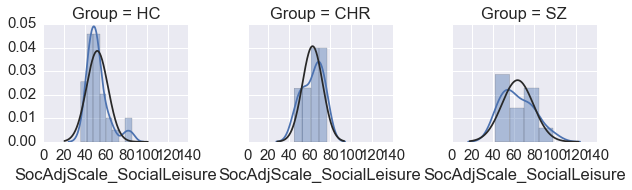

In [105]:
sns.set_context(font_scale=1.5)
g = sns.FacetGrid(data=raw, col='Group')
g.map(sns.distplot,'SocAdjScale_SocialLeisure',kde=True,fit=sp.stats.norm)

## PANSS Outliers

In [22]:
sx_outs = raw[['ID', 'Group', 'PANSS_PA', 'PANSS_PA_outliers','PANSS_NA', 'PANSS_NA_outliers','PANSS_DA',
               'PANSS_DA_outliers','PANSS_EA','PANSS_EA_outliers', 'PANSS_Dep_Anx', 'PANSS_Dep_Anx_outliers']].copy()


In [24]:
sx_outs = sx_outs[sx_outs.Group != 'HC']

### PANSS_PA

In [25]:
sx_outs.loc[sx_outs['PANSS_PA_outliers'] == 1]

,ID,Group,PANSS_PA,PANSS_PA_outliers,PANSS_NA,PANSS_NA_outliers,PANSS_DA,PANSS_DA_outliers,PANSS_EA,PANSS_EA_outliers,PANSS_Dep_Anx,PANSS_Dep_Anx_outliers
7,27136,SZ,30.0,1,8.0,0,15.0,0,4.0,0,5.0,0


In [26]:
sx_outs.PANSS_PA.describe()

count    52.000000
mean     14.192308
std       5.056692
min       7.000000
25%      10.000000
50%      13.000000
75%      18.000000
max      30.000000
Name: PANSS_PA, dtype: float64

In [27]:
print ('Test for Skewness')
p=sx_outs.groupby('Group')
p['PANSS_PA'].skew()

Test for Skewness


Group
CHR    1.013279
SZ     0.321784
Name: PANSS_PA, dtype: float64

In [28]:
g = sx_outs[['Group','PANSS_PA']].copy()
print ('Test for Kurtosis')
g.groupby('Group').apply(pd.DataFrame.kurt)

Test for Kurtosis


,PANSS_PA
Group,
CHR,0.208948
SZ,0.116925


### PANSS_NA

In [29]:
sx_outs.loc[sx_outs['PANSS_NA_outliers'] == 1]

,ID,Group,PANSS_PA,PANSS_PA_outliers,PANSS_NA,PANSS_NA_outliers,PANSS_DA,PANSS_DA_outliers,PANSS_EA,PANSS_EA_outliers,PANSS_Dep_Anx,PANSS_Dep_Anx_outliers


In [30]:
sx_outs.PANSS_NA.describe()

count    52.000000
mean     11.615385
std       5.164562
min       7.000000
25%       7.000000
50%      10.000000
75%      15.000000
max      27.000000
Name: PANSS_NA, dtype: float64

In [31]:
print ('Test for Skewness')
p['PANSS_NA'].skew()

Test for Skewness


Group
CHR    1.213561
SZ     0.879904
Name: PANSS_NA, dtype: float64

In [32]:
g = sx_outs[['Group','PANSS_NA']].copy()
print ('Test for Kurtosis')
g.groupby('Group').apply(pd.DataFrame.kurt)

Test for Kurtosis


,PANSS_NA
Group,
CHR,0.183574
SZ,-0.114477


### PANSS_DA

In [33]:
sx_outs.loc[sx_outs['PANSS_DA_outliers'] == 1]

,ID,Group,PANSS_PA,PANSS_PA_outliers,PANSS_NA,PANSS_NA_outliers,PANSS_DA,PANSS_DA_outliers,PANSS_EA,PANSS_EA_outliers,PANSS_Dep_Anx,PANSS_Dep_Anx_outliers
78,26159,CHR,16.0,0,7.0,0,10.0,1,6.0,0,4.0,0
81,26168,CHR,21.0,0,7.0,0,10.0,1,5.0,0,4.0,0


In [34]:
sx_outs.PANSS_DA.describe()

count    52.000000
mean      7.096154
std       3.543896
min       5.000000
25%       5.000000
50%       5.000000
75%       8.000000
max      18.000000
Name: PANSS_DA, dtype: float64

In [35]:
print ('Test for Skewness')
p['PANSS_DA'].skew()

Test for Skewness


Group
CHR    2.059699
SZ     1.001504
Name: PANSS_DA, dtype: float64

In [36]:
g = sx_outs[['Group','PANSS_DA']].copy()
print ('Test for Kurtosis')
g.groupby('Group').apply(pd.DataFrame.kurt)

Test for Kurtosis


,PANSS_DA
Group,
CHR,3.399041
SZ,-0.484275


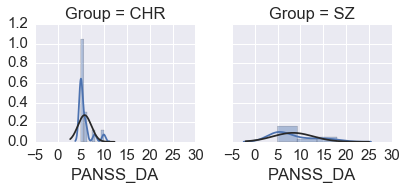

In [107]:
sns.set_context(font_scale=1.5)
g = sns.FacetGrid(data=sx_outs, col='Group')
g.map(sns.distplot,'PANSS_DA',kde=True,fit=sp.stats.norm)

### PANSS_EA

In [37]:
sx_outs.loc[sx_outs['PANSS_EA_outliers'] == 1]

,ID,Group,PANSS_PA,PANSS_PA_outliers,PANSS_NA,PANSS_NA_outliers,PANSS_DA,PANSS_DA_outliers,PANSS_EA,PANSS_EA_outliers,PANSS_Dep_Anx,PANSS_Dep_Anx_outliers
69,26125,CHR,9.0,0,17.0,0,6.0,0,7.0,1,14.0,1
77,26151,CHR,12.0,0,9.0,0,5.0,0,7.0,1,10.0,0


In [38]:
sx_outs.PANSS_EA.describe()

count    52.000000
mean      4.942308
std       1.526414
min       4.000000
25%       4.000000
50%       4.000000
75%       6.000000
max      10.000000
Name: PANSS_EA, dtype: float64

In [39]:
print ('Test for Skewness')
p['PANSS_EA'].skew()

Test for Skewness


Group
CHR    1.827094
SZ     1.131954
Name: PANSS_EA, dtype: float64

In [40]:
g = sx_outs[['Group','PANSS_EA']].copy()
print ('Test for Kurtosis')
g.groupby('Group').apply(pd.DataFrame.kurt)

Test for Kurtosis


,PANSS_EA
Group,
CHR,2.231884
SZ,0.132214


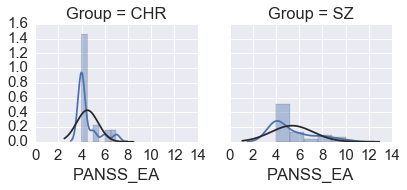

In [108]:
sns.set_context(font_scale=1.5)
g = sns.FacetGrid(data=sx_outs, col='Group')
g.map(sns.distplot,'PANSS_EA',kde=True,fit=sp.stats.norm)

### PANSS_Dep_Anx

In [41]:
sx_outs.loc[sx_outs['PANSS_Dep_Anx_outliers'] == 1]

,ID,Group,PANSS_PA,PANSS_PA_outliers,PANSS_NA,PANSS_NA_outliers,PANSS_DA,PANSS_DA_outliers,PANSS_EA,PANSS_EA_outliers,PANSS_Dep_Anx,PANSS_Dep_Anx_outliers
69,26125,CHR,9.0,0,17.0,0,6.0,0,7.0,1,14.0,1
13,27175,SZ,23.0,0,9.0,0,6.0,0,4.0,0,20.0,1


In [42]:
sx_outs.PANSS_Dep_Anx.describe()

count    52.000000
mean      7.692308
std       3.691742
min       4.000000
25%       5.000000
50%       6.000000
75%       9.000000
max      20.000000
Name: PANSS_Dep_Anx, dtype: float64

In [43]:
print ('Test for Skewness')
p['PANSS_Dep_Anx'].skew()

Test for Skewness


Group
CHR    1.164883
SZ     0.997987
Name: PANSS_Dep_Anx, dtype: float64

In [44]:
g = sx_outs[['Group','PANSS_Dep_Anx']].copy()
print ('Test for Kurtosis')
g.groupby('Group').apply(pd.DataFrame.kurt)

Test for Kurtosis


,PANSS_Dep_Anx
Group,
CHR,1.730718
SZ,0.370698


In [45]:
#Push dataframe to R to conduct statistical analyses
%Rpush raw
%R str(raw)

'data.frame':	87 obs. of  47 variables:
 $ ID                                : int  27120 27121 27122 27127 27131 27145 27164 27191 27193 27195 ...
 $ Group                             : Factor w/ 3 levels "CHR","HC","SZ": 2 2 2 2 2 2 2 2 2 2 ...
 $ Gender                            : Factor w/ 2 levels "female","male": 2 2 1 1 1 2 2 2 2 2 ...
 $ Age                               : int  46 53 55 50 45 40 45 42 26 51 ...
 $ Education                         : num  12 16 19 18 20 12 11 16 12 12 ...
 $ Ethnicity                         : num  1 1 1 1 1 4 1 1 1 1 ...
 $ IQ                                : num  94 109 130 114 114 88 101 96 109 96 ...
 $ DSMDisorder                       : num  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
 $ DSMDisorderType                   : num  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
 $ DSMcomorbidities                  : num  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
 $ IRI_EC_total                      : num  33 26 33 34 33 33 34 32 29 34 ...
 $ I

# Demographics

In [163]:
print ('Total Group Count')
beh.groupby('Group')['ID'].nunique()

Total Group Count


Group
CHR    27
HC     38
SZ     26
Name: ID, dtype: int64

In [46]:
print ('Total Group Count')
raw.groupby('Group')['ID'].nunique()

Total Group Count


Group
CHR    26
HC     35
SZ     26
Name: ID, dtype: int64

In [48]:
print ('Gender by Group')
raw.groupby('Group')['Gender'].value_counts()

Gender by Group


Group  Gender
CHR    male      17
       female     9
HC     male      20
       female    15
SZ     male      16
       female    10
dtype: int64

### Education

ANOVA for Education x Group


            Df Sum Sq Mean Sq F value Pr(>F)
Group        2    7.8   3.913   0.771  0.466
Residuals   78  396.0   5.078               
6 observations deleted due to missingness


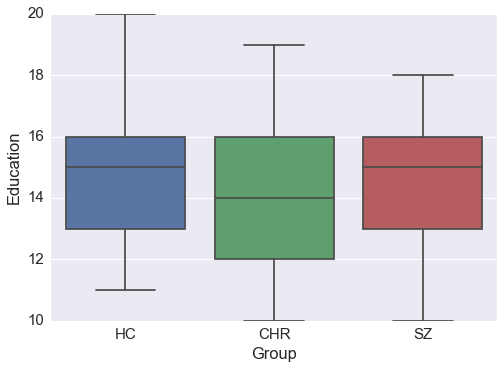

In [109]:
sns.set_context(font_scale=1.5)
sns.boxplot(x='Group',y='Education',data=raw)
print ('ANOVA for Education x Group')
%R ed.aov <- aov(Education ~ Group, data=raw)
%R print (summary(ed.aov))

### Age

ANOVA for Age x Group


            Df Sum Sq Mean Sq F value   Pr(>F)    
Group        2   3690  1844.9   19.36 1.21e-07 ***
Residuals   84   8003    95.3                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Age by Group
Group
CHR    21.846154
HC     30.428571
SZ     38.692308
Name: Age, dtype: float64


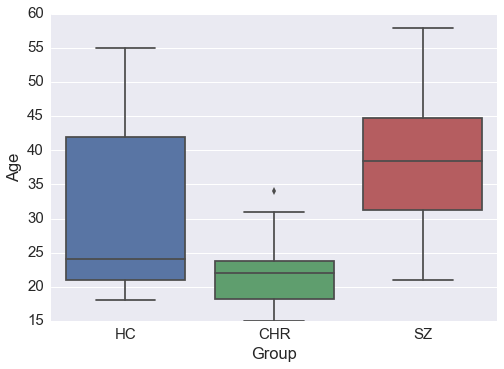

In [110]:
print ('ANOVA for Age x Group')
%R age.aov <- aov(Age ~ Group, data=raw)
%R print (summary(age.aov))

print ('Age by Group')
g=raw.groupby('Group')
print (g.Age.mean())

sns.set_context(font_scale=1.5)
sns.boxplot(x='Group',y='Age',data=raw)

### IQ

In [51]:
"""Dataframe dropping participants without an IQ value"""
raw_IQ = raw[np.isfinite(raw['IQ'])]

In [85]:
#Totals for IQ - only 2 missing from CHR group
print ('Total Group Count for IQ')
raw_IQ.groupby('Group')['ID'].nunique()

Total Group Count for IQ


Group
CHR    24
HC     35
SZ     26
Name: ID, dtype: int64

Group
CHR    106.791667
HC     112.057143
SZ     108.076923
Name: IQ, dtype: float64
ANOVA for IQ x Group


            Df Sum Sq Mean Sq F value Pr(>F)
Group        2    456   227.9   1.123   0.33
Residuals   82  16638   202.9               
2 observations deleted due to missingness


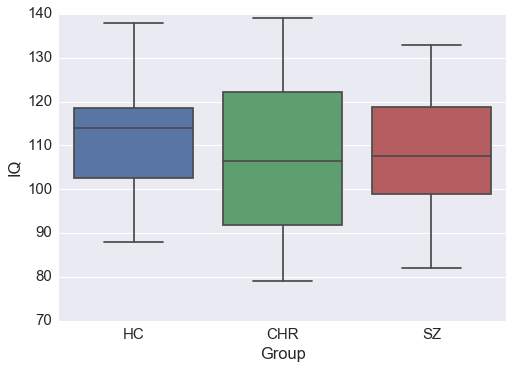

In [111]:
i = raw_IQ.groupby('Group')

print (i.IQ.mean())

sns.set_context(font_scale=1.5)
sns.boxplot(x='Group',y='IQ',data=raw_IQ)

%Rpush raw_IQ
print ('ANOVA for IQ x Group')
%R iq.aov <- aov(IQ ~ Group, data=raw)
%R print (summary(iq.aov))

# Measures

## Global Functioning Scale (name?)

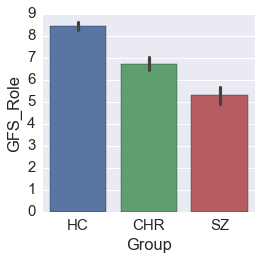

In [122]:
sns.set_context(font_scale=1.5)
sns.factorplot(y='GFS_Role',x='Group',units='ID',ci=68,kind='bar',data=raw)
plt.subplots_adjust(top=0.9)

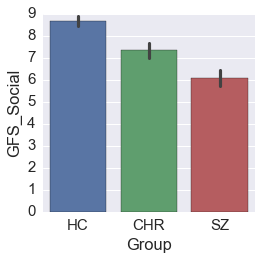

In [121]:
sns.set_context(font_scale=1.5)
sns.factorplot(y='GFS_Social',x='Group',units='ID',ci=68,kind='bar',data=raw)
plt.subplots_adjust(top=0.9)

## Social Adjustment Scale

In [55]:
x = raw.groupby('Group')

print('SAS Social Leisure Mean')
print(x.SocAdjScale_SocialLeisure.mean())

SAS Social Leisure Mean
Group
CHR    62.772727
HC     51.937500
SZ     63.680000
Name: SocAdjScale_SocialLeisure, dtype: float64


### Social Leisure

ANOVA on SAS Social Leisure x Group


            Df Sum Sq Mean Sq F value   Pr(>F)    
Group        2   2448  1224.1   8.189 0.000602 ***
Residuals   76  11361   149.5                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
8 observations deleted due to missingness


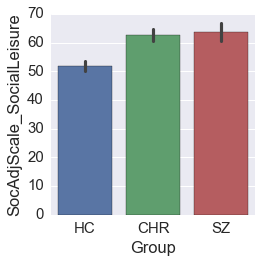

In [123]:
sns.set_context(font_scale=1.5)
sns.factorplot(y='SocAdjScale_SocialLeisure',x='Group',units='ID',ci=68,kind='bar',data=raw)

print ('ANOVA on SAS Social Leisure x Group')


%R sas_sl.aov <- aov(SocAdjScale_SocialLeisure ~ Group,data=raw)
%R print (summary(sas_sl.aov))

In [57]:
%R sas_sl.lsm <- lsmeans(sas_sl.aov, ~ Group)
%R print(sas_sl.lsm)

%R print(pairs(sas_sl.lsm))

 Group   lsmean       SE df lower.CL upper.CL
 CHR   62.77273 2.606715 76 57.58100 67.96445
 HC    51.93750 2.161374 76 47.63275 56.24225
 SZ    63.68000 2.445315 76 58.80973 68.55027

Confidence level used: 0.95 


 contrast    estimate       SE df t.ratio p.value
 CHR - HC  10.8352273 3.386222 76   3.200  0.0056
 CHR - SZ  -0.9072727 3.574148 76  -0.254  0.9651
 HC - SZ  -11.7425000 3.263603 76  -3.598  0.0016

P value adjustment: tukey method for comparing a family of 3 estimates 


### Work

            Df Sum Sq Mean Sq F value Pr(>F)  
Group        2   3837  1918.4   4.383 0.0158 *
Residuals   76  33266   437.7                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
8 observations deleted due to missingness


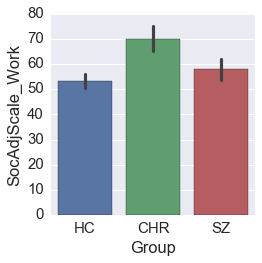

In [125]:
sns.set_context(font_scale=1.5)
sns.factorplot(y='SocAdjScale_Work',x='Group',units='ID',ci=68,kind='bar',data=raw)

%R sas_w.aov <- aov(SocAdjScale_Work ~ Group,data=raw)
%R print (summary(sas_w.aov))

In [59]:
%R sas_w.lsm <- lsmeans(sas_w.aov, ~ Group)
%R print(sas_w.lsm)

%R print(pairs(sas_w.lsm))

 Group   lsmean       SE df lower.CL upper.CL
 CHR   70.00000 4.362454 76 61.31142 78.68858
 HC    53.16129 3.757629 76 45.67732 60.64526
 SZ    58.00000 4.184319 76 49.66621 66.33379

Confidence level used: 0.95 


 contrast estimate       SE df t.ratio p.value
 CHR - HC 16.83871 5.757671 76   2.925  0.0125
 CHR - SZ 12.00000 6.044793 76   1.985  0.1228
 HC - SZ  -4.83871 5.623904 76  -0.860  0.6668

P value adjustment: tukey method for comparing a family of 3 estimates 


## Interpersonal Reactivity Index

ANOVA on Empathic concern x Group


            Df Sum Sq Mean Sq F value  Pr(>F)   
Group        2    383  191.52   6.509 0.00242 **
Residuals   79   2325   29.43                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
5 observations deleted due to missingness


ANOVA on Fantasy x Group


            Df Sum Sq Mean Sq F value Pr(>F)
Group        2    163   81.55   1.884  0.159
Residuals   79   3419   43.28               
5 observations deleted due to missingness


ANOVA on Personal Distress x Group


            Df Sum Sq Mean Sq F value  Pr(>F)   
Group        2  465.8  232.90   6.044 0.00361 **
Residuals   79 3044.2   38.53                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
5 observations deleted due to missingness


ANOVA on Perspective Taking x Group


            Df Sum Sq Mean Sq F value   Pr(>F)    
Group        2  398.4  199.20   9.188 0.000259 ***
Residuals   79 1712.8   21.68                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
5 observations deleted due to missingness


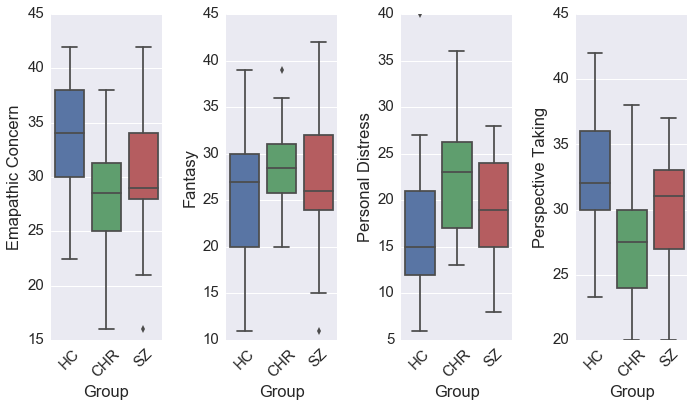

In [128]:
sns.set_context(font_scale=1.5)

print ('ANOVA on Empathic concern x Group')
%R ec.aov <- aov(IRI_EC_total ~ Group, data=raw)
%R print (summary(ec.aov))
fig = plt.figure(figsize=(10, 6))
iri = fig.add_subplot(141)
sns.boxplot(y='IRI_EC_total', x='Group', data = raw)
plt.ylabel('Emapathic Concern')
plt.xticks(rotation=45)

print ('ANOVA on Fantasy x Group')
%R fs.aov <- aov(IRI_FS_total ~ Group, data=raw)
%R print (summary(fs.aov))
iri = fig.add_subplot(142)
sns.boxplot(y='IRI_FS_total', x='Group', data = raw)
plt.ylabel('Fantasy')
plt.xticks(rotation=45)

print ('ANOVA on Personal Distress x Group')
%R pd.aov <- aov(IRI_PD_total ~ Group, data=raw)
%R print (summary(pd.aov))
iri = fig.add_subplot(143)
sns.boxplot(y='IRI_PD_total', x='Group', data = raw)
plt.ylabel('Personal Distress')
plt.xticks(rotation=45)

print ('ANOVA on Perspective Taking x Group')
%R pt.aov <- aov(IRI_PT_total ~ Group, data=raw)
%R print (summary(pt.aov))
iri = fig.add_subplot(144)
sns.boxplot(y='IRI_PT_total', x='Group', data = raw)
plt.ylabel('Perspective Taking')
plt.xticks(rotation=45)
fig.tight_layout()

In [61]:
print ('Followup on IRI_EC x Group')
%R ec.lsm <- lsmeans(ec.aov, ~ Group)
%R print(ec.lsm)
%R print(pairs(ec.lsm))
print ('Followup on IRI_PT x Group')
%R pt.lsm <- lsmeans(pt.aov, ~ Group)
%R print(pt.lsm)
%R print(pairs(pt.lsm))
print ('Followup on IRI_PD x Group')
%R pd.lsm <- lsmeans(pd.aov, ~ Group)
%R print(pd.lsm)
%R print(pairs(pd.lsm))

Followup on IRI_EC x Group


 Group   lsmean        SE df lower.CL upper.CL
 CHR   28.50000 1.1072837 79 26.29601 30.70399
 HC    33.64848 0.9442947 79 31.76891 35.52806
 SZ    30.56000 1.0849120 79 28.40054 32.71946

Confidence level used: 0.95 


 contrast  estimate       SE df t.ratio p.value
 CHR - HC -5.148485 1.455256 79  -3.538  0.0019
 CHR - SZ -2.060000 1.550197 79  -1.329  0.3835
 HC - SZ   3.088485 1.438307 79   2.147  0.0869

P value adjustment: tukey method for comparing a family of 3 estimates 


Followup on IRI_PT x Group


 Group   lsmean        SE df lower.CL upper.CL
 CHR   27.79167 0.9504740 79 25.89980 29.68354
 HC    33.06970 0.8105670 79 31.45630 34.68309
 SZ    30.04000 0.9312705 79 28.18635 31.89365

Confidence level used: 0.95 


 contrast  estimate       SE df t.ratio p.value
 CHR - HC -5.278030 1.249168 79  -4.225  0.0002
 CHR - SZ -2.248333 1.330664 79  -1.690  0.2155
 HC - SZ   3.029697 1.234619 79   2.454  0.0427

P value adjustment: tukey method for comparing a family of 3 estimates 


Followup on IRI_PD x Group


 Group   lsmean       SE df lower.CL upper.CL
 CHR   22.33333 1.267110 79 19.81121 24.85545
 HC    16.54545 1.080595 79 14.39458 18.69632
 SZ    19.12000 1.241509 79 16.64884 21.59116

Confidence level used: 0.95 


 contrast  estimate       SE df t.ratio p.value
 CHR - HC  5.787879 1.665308 79   3.476  0.0024
 CHR - SZ  3.213333 1.773954 79   1.811  0.1725
 HC - SZ  -2.574545 1.645913 79  -1.564  0.2671

P value adjustment: tukey method for comparing a family of 3 estimates 


## Chapman

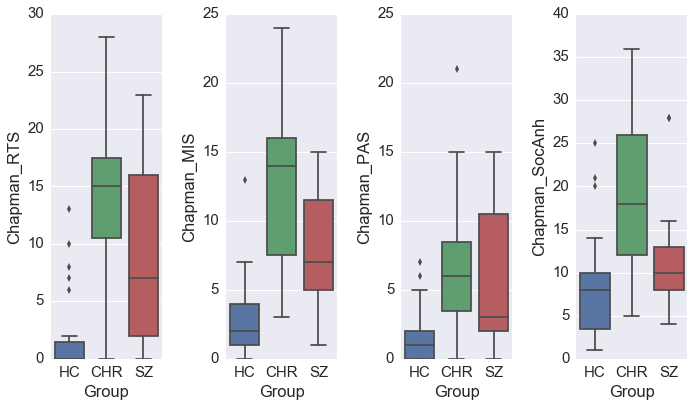

In [131]:
sns.set_context(font_scale=1.5)
fig = plt.figure(figsize=(10, 6))
chap = fig.add_subplot(141)
sns.boxplot(y='Chapman_RTS', x='Group', data = raw)
chap = fig.add_subplot(142)
sns.boxplot(y='Chapman_MIS', x='Group', data = raw)
chap = fig.add_subplot(143)
sns.boxplot(y='Chapman_PAS', x='Group', data = raw)
chap = fig.add_subplot(144)
sns.boxplot(y='Chapman_SocAnh', x='Group', data = raw)
fig.tight_layout()

## Positive and Negative Syndrome Scale

In [63]:
print ('Between-group t-tests on PANSS Positive - Clinical Groups')
misc.ttest_2s(raw[raw.Group == 'CHR']['PANSS_PA'],raw[raw.Group == 'SZ']['PANSS_PA'])

print ('Between-group t-tests on PANSS Negative - Clinical Groups')
misc.ttest_2s(raw[raw.Group == 'CHR']['PANSS_NA'],raw[raw.Group == 'SZ']['PANSS_PA'])

print ('Between-group t-tests on PANSS Disorganized - Clinical Groups')
misc.ttest_2s(raw[raw.Group == 'CHR']['PANSS_DA'],raw[raw.Group == 'SZ']['PANSS_DA'])

print ('Between-group t-tests on PANSS Excitement - Clinical Groups')
misc.ttest_2s(raw[raw.Group == 'CHR']['PANSS_EA'],raw[raw.Group == 'SZ']['PANSS_EA'])

print ('Between-group t-tests on PANSS Depression & Anxiety - Clinical Groups')
misc.ttest_2s(raw[raw.Group == 'CHR']['PANSS_Dep_Anx'],raw[raw.Group == 'SZ']['PANSS_Dep_Anx'])

Between-group t-tests on PANSS Positive - Clinical Groups
t(50) = -3.37, p = 0.001
Between-group t-tests on PANSS Negative - Clinical Groups
t(50) = -5.51, p = 0.000
Between-group t-tests on PANSS Disorganized - Clinical Groups
t(50) = -2.79, p = 0.007
Between-group t-tests on PANSS Excitement - Clinical Groups
t(50) = -2.16, p = 0.035
Between-group t-tests on PANSS Depression & Anxiety - Clinical Groups
t(50) = -2.44, p = 0.018


(-2.4393573736303646, 0.018304443150451075)

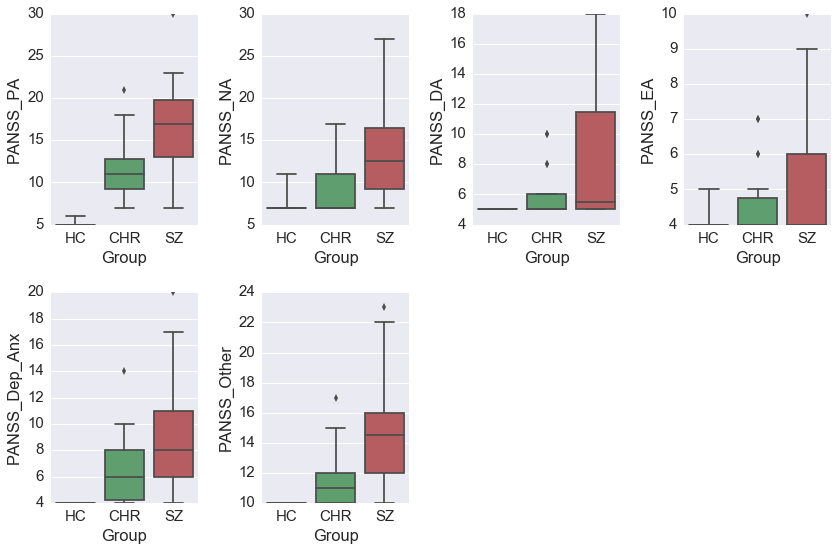

In [133]:
sns.set_context(font_scale=1.5)
fig = plt.figure(figsize=(12, 8))
pns = fig.add_subplot(241)
sns.boxplot(y='PANSS_PA', x='Group', data = raw)
pns = fig.add_subplot(242)
sns.boxplot(y='PANSS_NA', x='Group', data = raw)
pns = fig.add_subplot(243)
sns.boxplot(y='PANSS_DA', x='Group', data = raw)
pns = fig.add_subplot(244)
sns.boxplot(y='PANSS_EA', x='Group', data = raw)
pns = fig.add_subplot(245)
sns.boxplot(y='PANSS_Dep_Anx', x='Group', data = raw)
pns = fig.add_subplot(246)
sns.boxplot(y='PANSS_Other', x='Group', data = raw)
fig.tight_layout()

# Modeling

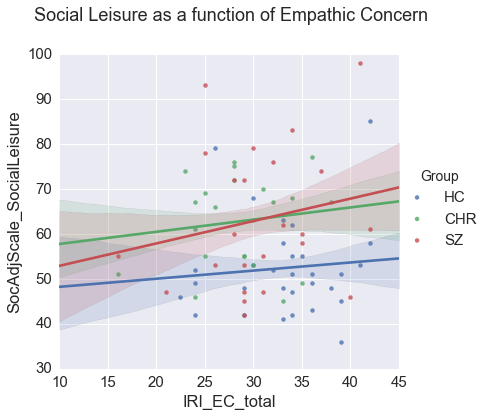

In [156]:
sns.set_context(font_scale=1.5)
g = sns.lmplot(y='SocAdjScale_SocialLeisure',x='IRI_EC_total',hue='Group',
           units='ID',ci=68,data=raw, size=6)
g = sns.plt.ylim(30,100)
plt.subplots_adjust(top=0.87)
sns.plt.suptitle('Social Leisure as a function of Empathic Concern', fontsize=18)

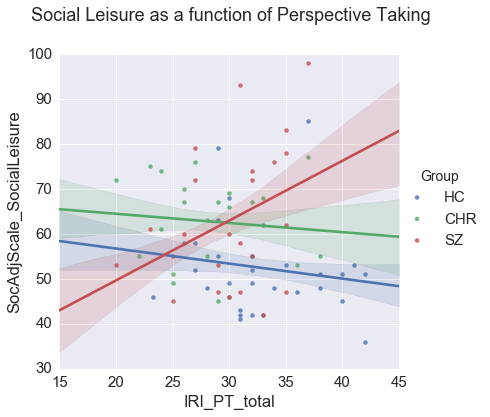

In [153]:
sns.set_context(font_scale=1.5)
g = sns.lmplot(y='SocAdjScale_SocialLeisure',x='IRI_PT_total',hue='Group',
           units='ID',ci=68,data=raw, size=6)
g = sns.plt.ylim(30,100)
plt.subplots_adjust(top=0.87)
sns.plt.suptitle('Social Leisure as a function of Perspective Taking', fontsize=18)

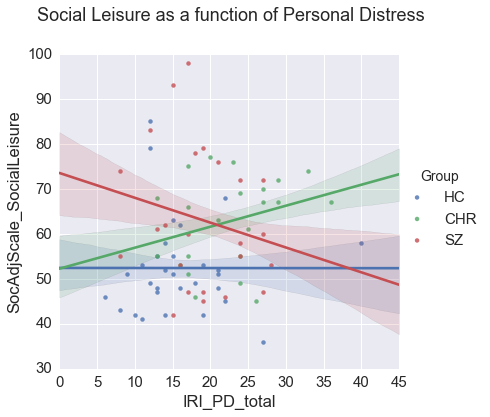

In [152]:
g = sns.lmplot(y='SocAdjScale_SocialLeisure',x='IRI_PD_total',hue='Group',
           units='ID',ci=68,data=raw, size=6)
g = sns.plt.ylim(30,100)
plt.subplots_adjust(top=0.87)
sns.plt.suptitle('Social Leisure as a function of Personal Distress', fontsize=18)

In [162]:

%R fm1 <- lm(SocAdjScale_SocialLeisure ~  Group, data=raw)
%R fm2 <- lm(SocAdjScale_SocialLeisure ~  Group + IRI_EC_total, data=raw)
%R fm3 <- lm(SocAdjScale_SocialLeisure ~  Group + IRI_EC_total + Age, data=raw)

%R fm.aov <- anova(fm1, fm2, fm3)
%R print(fm.aov)


Error in anova.lmlist(object, ...) : 
  models were not all fitted to the same size of dataset

Error in print(fm.aov) : object 'fm.aov' not found
